# Metis Data Science Bootcamp
## San Francisco, Winter 2020
### Project 4: Election Reporting Sentiment Analysis

### Topic Modeling

In [1]:
import sys
import re
import os.path
import requests
import time
import pandas as pd
import numpy as np

from os import path

import matplotlib.pyplot as plt
import seaborn as sns

from pymongo import MongoClient

In [2]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

import spacy
from spacy import displacy
from pprint import pprint
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

import re
import string

from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm")

In [3]:
db_client = MongoClient()
db_news = db_client['news_search']
db_news_col = db_news['search_result']

In [4]:
db_news_content = db_news['news_content']
cursor = db_news_content.find({}, {'_id':0, 'name': 1, 'text': 1, 'url' : 1, 'base_url' : 1, 'pub_date': 1})

In [5]:
cursor = db_news_content.find({}, {'_id':0, 'name': 1, 'text': 1, 'url' : 1, 'base_url' : 1, 'pub_date': 1})
print(len(list(cursor)))

3795


In [6]:
db_news_content = db_news['news_content']



In [7]:
cursor = db_news_content.find({}, {'_id':1, 'text': 1, 'short_text' : 1 , 'prop_nouns' : 1})
articles = list(cursor)
X_nouns = []
X_what = []
y = []
for article in articles :
    X_what.append(article['short_text'])
    y.append(article['_id'])

In [8]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

## Start with Count Vectorizing

In [9]:
# build our corpus
corpus = []
cursor = db_news_content.find({}, {'_id':1, 'text': 1, 'short_text' : 1, 'prop_nouns' : 1})
for article in list(cursor) :
    corpus.append(article['short_text'])


In [10]:
vectorizer = CountVectorizer(stop_words='english', max_df=1.5, max_features=80, ngram_range=(1,2))
cv = vectorizer.fit(corpus)

X_cv_what = cv.transform(X_what)
X_cv_what_df = pd.DataFrame(X_cv_what.toarray(), columns=vectorizer.get_feature_names())


## Vectorize with TF-IDF

In [11]:
tf_vect = TfidfVectorizer(stop_words='english', max_df=1.5, max_features=80, ngram_range=(1,2))
tfidf = tf_vect.fit(corpus)

X_tf_what = tfidf.transform(X_what)
X_tf_what_df = pd.DataFrame(X_cv_what.toarray(), columns=vectorizer.get_feature_names())


In [12]:
lda_model = LatentDirichletAllocation(n_components=8,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=40,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

lda_output = lda_model.fit_transform(X_cv_what)

In [13]:
lda_df = pd.DataFrame(lda_output)

Now apply PCA to the TF-IDF vectorized data

In [14]:
# Take all of the data and plot it on 2 dimensions
pca = PCA(n_components=8)
pca.fit(lda_df)
pca_lda_what = pca.transform(lda_df)

In [15]:
# Take all of the data and plot it on 2 dimensions
pca = PCA(n_components=8)
pca.fit(X_tf_what_df)
pca_tf_what = pca.transform(X_tf_what_df)

In [16]:
X_pca_lda_df = pd.DataFrame(pca_lda_what)
X_pca_lda_df['_id'] = y

In [17]:
X_pca_tf_df = pd.DataFrame(pca_tf_what)
X_pca_tf_df['_id'] = y

Now Try Clustering

In [18]:
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmykbrgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [19]:
plt.rcParams['figure.figsize'] = [6,6]
sns.set_style("whitegrid")
sns.set_context("talk")

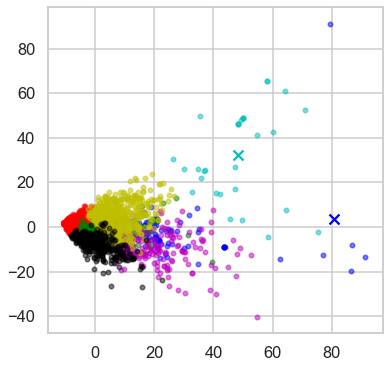

In [20]:
num_clusters = 8
km = KMeans(n_clusters=num_clusters,random_state=100,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(pca_tf_what)
display_cluster(pca_tf_what,km,num_clusters)

In [21]:
km.labels_

array([1, 1, 1, ..., 1, 1, 5], dtype=int32)

In [22]:
# Add the cluster assignment to the dataframe
X_pca_tf_df['cluster'] = km.labels_

Add the cluster ID to the dataframe

In [23]:
X_pca_tf_df.head()

,0,1,2,3,4,5,6,7,_id,cluster
0,-5.731547,-1.233145,-2.594547,-4.296178,-0.413558,-0.606760,-1.074658,1.858781,5e4d93b4bdc708691b5225e0,1
1,-8.664846,1.174640,-0.104269,-2.859742,-0.386958,-0.755749,-0.269392,0.170506,5e4d93b5bdc708691b5225e1,1
2,-4.540552,-3.933435,-3.851926,-2.598602,-0.335037,-2.821694,-2.071665,2.602415,5e4d93b5bdc708691b5225e2,1
3,-1.523646,-2.907617,-0.646962,-1.645892,-0.043419,-0.016066,-4.797053,-1.337286,5e4d93b5bdc708691b5225e3,1
4,-10.562520,1.891049,0.946712,-2.007829,-0.092276,-0.344332,-0.194934,0.262232,5e4d93b6bdc708691b5225e4,1


In [24]:
db_client = MongoClient()
db_news = db_client['news_search']
db_news_col = db_news['search_result']
db_news_content = db_news['news_content']

In [26]:
def get_feature_count(vect, data, num):
    out_list = []
    for i in range(1,num+1):
        idx_list = data.argsort()
        out_list.append([vect.get_feature_names()[idx_list[-i]], data[idx_list[-i]]])
        
    return(out_list)

In [27]:
def print_feature_count(vect, data, num):
    for pair in get_feature_count(vect, data, num):
        print(pair)

In [28]:
vectorizer = CountVectorizer(stop_words='english', max_df=1.5, max_features=80, ngram_range=(1,1))
topic_list = []
# Run through each cluster and make a cluster corpus
for cluster in range(7) :
    cluster_corpus = ''
    for idx in X_pca_tf_df.index :
        if X_pca_tf_df.loc[idx, 'cluster'] == cluster :
            cursor = db_news_content.find({'_id': X_pca_tf_df.loc[idx, '_id']},{'short_text': 1})
            article = list(cursor)[0]
            cluster_corpus += article['short_text']
    print(f'Cluster {cluster}')
    print(len(cluster_corpus))
    
    # Run the cluster corpus through count vectorizer
    corpus_count = vectorizer.fit_transform([cluster_corpus])
    
    # print the top words
    topic_list.append(get_feature_count(vectorizer, corpus_count.toarray()[0], 5))

Cluster 0
823932
Cluster 1
2870792
Cluster 2
658167
Cluster 3
290227
Cluster 4
1093909
Cluster 5
2217934
Cluster 6
1122579


In [29]:
topic_list

[[['biden', 4604],
  ['sander', 1168],
  ['iowa', 1026],
  ['trump', 974],
  ['hampshire', 927]],
 [['sander', 4088],
  ['warren', 2814],
  ['trump', 2706],
  ['biden', 2706],
  ['buttigieg', 2468]],
 [['warren', 3341],
  ['sander', 975],
  ['iowa', 618],
  ['hampshire', 565],
  ['debate', 480]],
 [['iowa', 1005],
  ['caucus', 905],
  ['result', 889],
  ['sander', 443],
  ['buttigieg', 400]],
 [['sander', 4713],
  ['trump', 1545],
  ['biden', 1304],
  ['voter', 1027],
  ['buttigieg', 973]],
 [['buttigieg', 4871],
  ['sander', 3885],
  ['iowa', 3761],
  ['caucus', 2257],
  ['biden', 2220]],
 [['bloomberg', 4765],
  ['trump', 1730],
  ['debate', 1371],
  ['sander', 1286],
  ['warren', 910]]]

In [ ]:
Topic #0: biden voter poll steyer carolina
Topic #1: trump biden democrats sander election
Topic #2: buttigieg iowa caucus campaign result
Topic #3: plan health care policy issue
Topic #4: sander campaign vote primary supporter
Topic #5: people know right like year
Topic #6: bloomberg campaign debate york billionaire
Topic #7: warren woman campaign debate hampshire

In [60]:
a_idx_list = a_cc.argsort()
a_idx_list

array([41, 14, 35, 52, 42,  1, 21, 36, 16, 67, 55, 68, 43, 61, 28, 24, 65,
        3, 57, 63,  0,  9, 45, 49, 34, 25, 60, 53, 47, 15, 32, 79,  7, 22,
       18, 40, 13, 38, 11, 56, 10, 54, 20, 76, 75, 19, 73, 77, 26, 37, 46,
       48,  8, 50, 39, 66, 12, 29, 71, 72, 62, 31, 23, 33, 69, 78, 64, 58,
       17, 30, 44, 51, 27,  4,  2, 70,  5, 74, 59,  6])

In [64]:
feature_count = a_cc[a_idx_list[-2]]
feature_name = vectorizer.get_feature_names()[a_idx_list[-2]]

In [65]:
feature_name, feature_count

('campaign', 3775)

In [79]:
print_feature_count(vectorizer, corpus_count.toarray()[0], 10)

['campaign', 3775]
['sander', 3280]
['warren', 2702]
['buttigieg', 2569]
['trump', 2513]
['biden', 2501]
['bloomberg', 2376]
['iowa', 2046]
['primary', 1718]
['people', 1715]
